In [1]:
import json
import os
import sys
import fnmatch


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('avg_stats.csv')#pd.read_csv('BBGM_League_7_all_seasons_Average_Stats.csv')
df.shape

(22587, 76)

In [3]:
y = df.iloc[:,-15:]
X = df.iloc[:,11:-17]
y = y[(X['AST%'] >0) & (X['AST%'] < 100)]
X = X[(X['AST%'] >0) & (X['AST%'] < 100)]
X['MP'] = df.MP
X['Hgt'] = df['Hgt']
df.columns


Index(['pid', 'Name', 'Pos', 'DraftPick', 'Age', 'Salary', 'Team', 'Season',
       'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'TOV', 'STL', 'Blk', 'BA', 'PF',
       'PTS', 'AtRimFG', 'AtRimFGA', 'AtRimFGP', 'LowPostFG', 'LowPostFGA',
       'LowPostFGP', 'MidRangeFG', 'MidRangeFGA', 'MidRangeFGP', 'PER', 'ORtg',
       'DRtg', 'OWS', 'DWS', 'WS', 'WS/48', 'EWA', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '+/-',
       'Ovr', 'Pot', 'Hgt', 'Str', 'Spd', 'Jmp', 'End', 'Ins', 'Dnk', 'FT.1',
       '2Pt', '3Pt', 'oIQ', 'dIQ', 'Drb', 'Pss', 'Reb'],
      dtype='object')

In [4]:
stat_list = ['FG','FGA','3P',"3PA",'FT','FTA',\
             'ORB','DRB','TRB','AST','TOV','STL',"Blk",\
             'PF','PTS']
for name in stat_list:
    den = np.maximum(1,df.MP)
    #if name in ['OWS','DWS']:
    #    den = den*df['G']
    #X[name] = df[name]
    X[name + 'p36'] = 36* df[name]/den
    X[name + 'p100'] = X[name + 'p36']*4/3

X['3PtP'] = (2/(1+np.exp(-X['3PAp100']))-1)*X['3P%']/100
X['Creation'] = X['ASTp100']*0.1843+(X['PTSp100']+X['TOVp100'])*0.0969-2.3021*X['3PtP']+0.0582*(X['ASTp100']*(X['PTSp100']+X['TOVp100'])*X['3PtP'] )-1.1942
X['Load'] = (X['ASTp100']-(0.38*X['Creation'])*0.75)+X['FGAp100']+X['FTAp100']*0.44+X['Creation']+X['TOVp100']
X['cTOV'] = X['TOVp100']/X['Load']
X['DPM'] = X['Blkp100']*0.802+X['DRBp100']*0.42-4.7-0.07551*X['PFp100']+1.597019*X['STLp100']-0.26385*X['TOVp100']
X['OPM'] = -8.57647+0.6111*X['PTSp100']-0.33918*(0.44*X['FTAp100']+X['FGAp100'])+0.440814*X['FTAp100']+0.379745*X['3PAp100']+0.634044*X['ASTp100']+0.77827*X['ORBp100']-1.08855*X['TOVp100']+0.26262*X['STLp100']
X['BPM'] = X['OPM'] + X['DPM']
X['Age'] = df['Age']

#X['PassP'] = ((X['ASTp100']-(0.38*X['Creation']))*0.752+ X['Creation'] + X['TOVp100']) ** 0.67
#'OPM','DPM','cTOV','Load'#stat_list[:-2]+
X = X[[_ for _ in X.columns if '%A' in _ or _[-1]=='r' or 'FGP' in _ or "+/-" in _ or 'p36' in _ or _ in (['OPM','BPM','DPM','Creation','cTOV','Load','Age','MP'])]]
if False:
    X = X[[_ for _ in X.columns if not '3P' in _]]
    X = X[[_ for _ in X.columns if not 'Rim' in _]]
    X = X[[_ for _ in X.columns if not 'Post' in _]]
    X = X[[_ for _ in X.columns if not 'Mid' in _]]
    X = X[[_ for _ in X.columns if not 'TOV' in _]]
    X = X[[_ for _ in X.columns if not 'Blk' in _]]
    X = X[[_ for _ in X.columns if not 'ORB' in _]]
    X = X[[_ for _ in X.columns if not 'DRB' in _]]
    X = X[[_ for _ in X.columns if not 'STL' in _]]
    X = X[[_ for _ in X.columns if not 'DPM' in _]]
    X = X[[_ for _ in X.columns if not 'OPM' in _]]
    X = X[[_ for _ in X.columns if not 'BPM' in _]]
    X = X[[_ for _ in X.columns if not '+/-' in _]]

replacement_filter = (df.Salary > 0.5) & (df.Salary < 1.0)
replacement_player_mean_bs = X[replacement_filter].mean()
replacement_player_std_bs = X[replacement_filter].std()
replacement_player_cov_bs = X[replacement_filter].cov()

replacement_player_mean_r = y[replacement_filter].mean()
replacement_player_std_r = y[replacement_filter].std()
replacement_player_cov_r = y[replacement_filter].cov()


replacement_player_mean_r

X.columns


/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Index(['AtRimFGP', 'LowPostFGP', 'MidRangeFGP', '3PAr', 'FTr', '+/-', 'MP',
       'FGp36', 'FGAp36', '3Pp36', '3PAp36', 'FTp36', 'FTAp36', 'ORBp36',
       'DRBp36', 'TRBp36', 'ASTp36', 'TOVp36', 'STLp36', 'Blkp36', 'PFp36',
       'PTSp36', 'Creation', 'Load', 'cTOV', 'DPM', 'OPM', 'BPM', 'Age'],
      dtype='object')

In [5]:
np.round(replacement_player_std_r).astype(np.int)
#_ =  plt.hist(X['OWSp36'],150)

Hgt     14
Str     10
Spd     15
Jmp     16
End     11
Ins     12
Dnk     11
FT.1    11
2Pt     11
3Pt     11
oIQ      8
dIQ      9
Drb     10
Pss     10
Reb     11
dtype: int64

In [6]:
from sklearn import neural_network
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import  multioutput
from sklearn import ensemble
from sklearn import svm

In [7]:
fexp = preprocessing.PolynomialFeatures(degree=2,interaction_only=True)
scalerX = preprocessing.RobustScaler()
scalery = preprocessing.StandardScaler()
prescale_X = scalerX.fit_transform(X)
prescale_y = scalery.fit_transform(y)
prescale_X = fexp.fit_transform(prescale_X)

/Users/lkeselma/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/lkeselma/anaconda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
trials = 1
ts = []
for i in range(trials):
    #clf = neural_network.MLPRegressor((36,5,24,36),'tanh',solver='adam',max_iter=1000)
    #clf = neural_network.MLPRegressor((),'identity',solver='lbfgs',alpha=5e2,tol=1e-9)
    #clf = multioutput.MultiOutputRegressor(linear_model.SGDRegressor(penalty='l2',alpha=5e2,eta0=1e-6,tol=1e-12,max_iter=50,verbose=True))
    clf = multioutput.MultiOutputRegressor(linear_model.ElasticNet(alpha=5e-3))
    #clf = ensemble.ExtraTreesRegressor(8,criterion='mae',max_depth=3,verbose=1)
    #clf = multioutput.MultiOutputRegressor(svm.SVR())
    clf.fit(prescale_X,prescale_y)
    yt = scalery.inverse_transform(clf.predict(prescale_X))
    err = np.linalg.norm(yt-y)
    ts.append((err,clf))

In [9]:
#np.array([est.alpha_ for est in clf.estimators_]).mean()
#0.007250734067011631-7e-3

In [10]:
ts = sorted(ts)[::1] # why not the biggest error
print(ts[0][0])
clf = ts[0][1]

3405.682738690294


In [11]:
col_names = X.columns
col_names = fexp.get_feature_names(X.columns)

for i,c in enumerate(y.columns):
    coeffs = clf.estimators_[i].coef_ 
    v = np.argsort(abs(coeffs))[::-1]
    print(c)
    coeffs2 = [(coeffs[i2],col_names[i2]) for i2 in v[:10]]
    #for v,n in sorted(coeffs2,reverse=True):
    #    print('{:.2f} * {} + '.format(v,n),end='')
    print('| Variable | Coeff |')
    print('|----------|-------|')
    for v,n in sorted(coeffs2,reverse=True):
        print('|{:25s}|{:.2f}|'.format(n,v))
    #for v,n in sorted(coeffs2,reverse=True):
    #    print('\t{:25s}\t{:.2f}'.format(n,v))


Hgt
| Variable | Coeff |
|----------|-------|
|Blkp36                   |0.45|
|PFp36                    |0.44|
|TRBp36                   |0.19|
|DRBp36                   |0.17|
|ORBp36                   |0.16|
|FTAp36                   |0.10|
|MP ASTp36                |0.08|
|MP PFp36                 |0.08|
|Creation                 |-0.09|
|ASTp36                   |-0.11|
Str
| Variable | Coeff |
|----------|-------|
|MP                       |0.31|
|FTAp36                   |0.28|
|FGp36                    |0.26|
|FGAp36                   |0.20|
|+/-                      |0.13|
|TOVp36                   |0.13|
|ORBp36                   |0.09|
|3Pp36                    |-0.16|
|PFp36                    |-0.19|
|ASTp36                   |-0.25|
Spd
| Variable | Coeff |
|----------|-------|
|Blkp36                   |0.35|
|MP                       |0.16|
|FTr                      |0.13|
|AtRimFGP                 |0.12|
|MP PFp36                 |-0.13|
|DRBp36                   |-0.1

In [12]:
GEN_YEAR = 2019
tyear = [GEN_YEAR]
#if tyear[0] < 1980:
#    print("MY PARSING OF THE TABLES IS WRONG WITHOUT the 2PA/3PA TRACKS")
#    raise

CURRENT_YEAR = 2019
all_tables = {}
for ty in tyear:
    all_tables[ty] = np.load('cbb_{}.pkl'.format(ty))
teams = all_tables[tyear[0]].keys()


In [13]:
player_stats = {k:{} for k in tyear}
table_columns = {}
rosters = {}
for ty in tyear:
    tables = all_tables[ty]

    for team in tables:
        team_tables =  tables[team]
        for table_name in team_tables:
            if table_name in ['draft-rights','team_and_opponent','conf','name','logo']:
                continue
            table = team_tables[table_name].fillna(0)
            #print(table_name)
            #print(table.index)
            for row in table.itertuples():
                name = row[0]
                name = name.replace('\xa0\xa0',' ')
                if name == 'Team Totals':
                    continue
                nsplit = name.split(' ')
                if nsplit[-1] in ['Jr.','Sr.','I','II','III',"IV",'(TW)']:
                    name = ' '.join(nsplit[:-1])
                rosters[name] = team
                player_table = player_stats[ty].get(name,{})
                player_row = player_table.get(table_name,[])
                player_row = player_row + [row]

                player_table[table_name] = player_row
                player_stats[ty][name] = player_table
                #if name == 'Dennis Smith Jr.' or name == 'Luka Doncic':
                #    print(player_stats[ty][name],team)
            table_columns[table_name] = table.columns

In [14]:
rosters_conf= {k: all_tables[GEN_YEAR][v]['conf'] for k,v in rosters.items()}
#all_tables[2019]['gonzaga']['roster']

In [15]:
table_mask = {}
for table in table_columns:
    table_mask[table] = [_.strip() !=''  for _ in table_columns[table] ]
    table_columns[table] = [_ for _ in table_columns[table] if _.strip() != '']
#for player in player_stats:
#    for table_in in player_stats[player]:
#        if 'on_off' in table_in or 'salaries' in table_in:
#            continue
#        if len(player_stats[player][table_in]) > 1:
#            pass
            #print(player,table_in,'MP' in player_stats[player][table_in][0]._fields)
            #print(player_stats[player][table_in][0])

In [16]:
# add playoff data to normal data
if False:
    for ty in tyear:
        for player in player_stats[ty]:
            for table_in in player_stats[ty][player]:
                tableN = table_in.split('_')
                tableS = '_'.join(tableN[1:])
                if 'playoffs'==tableN[0] and not table_in in ['playoffs_pbp']:
                    #print(table_in)
                    if tableS in player_stats[ty][player]:
                        player_stats[ty][player][tableS] += player_stats[ty][player][table_in]

In [17]:
for ty in tyear:
    for player in player_stats[ty]:
        for tt in player_stats[ty][player]:
            if tt in ['team_stats','team_stats_conf']:
                continue
            new_rows = []
            for tablet in player_stats[ty][player][tt]:
                vector = [_ if _ != '' else '0.0' for _ in tablet[1:]]
                vector = [(float(_.replace('%',''))/100 if type(_) == str and'%' in _ else _) for _ in vector]
                if 'on_off' in tt:
                    vector = vector[1:]
                if 'contracts' in tt:
                    vector = vector[1:-2]
                if tt in ['salaries2','contracts']:
                    vector = [_.replace(',','').replace('$','') for _ in vector]
                try:
                    v2 = np.array(vector).astype(np.float)
                except:
                    v2 = vector
                new_rows.append(vector)
            a = np.array(new_rows)

            if 'MP' in table_columns[tt] and not tt in ['pbp','on_off','on_off_p']:
                try:
                    a = a.astype(np.float)
                except:
                    a = list(a)
                    a[0] = np.array([float(_) for _ in a[0]])
                    a[1] = np.array([float(_) for _ in a[1]])
                    a = np.array(a)
                try:
                    mins = a[:,table_columns[tt].index('MP')].reshape((-1,1))
                    new_rows = ((a.T @ mins)/mins.sum()).T
                    a = new_rows
                except:
                    print(tt,a.shape,player,a,mins)
                    pass

            player_stats[ty][player][tt] = a


/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [18]:
#player_stats[2019]['Brandon Clarke']

In [20]:
player_vectors = []
player_names = []
player_years = []
player_scales = []
player_heights = []
player_confs = []
player_composites = []
compNames = ['CUsage','CPassing','CTurnovers','CRim','CLowPost','CMidRange','C3Point','CFreeThrow','CRebound','CSteal','CBlock','CFouling','CDrawFoul']

for ty in tyear:
    for name in player_stats[ty]:
        #name = 'Jimmy Butler'
        #name = 'Ben Simmons'
        stats = player_stats[ty][name]
        if not 'totals' in stats:
            if ty == GEN_YEAR and name in player_stats[tyear[-1]] and 'totals' in player_stats[tyear[-1]][name]:
                stats = player_stats[tyear[-1]][name]
            else:
                continue

        try:
            ht = [int(_) for _ in stats['roster'][0][3].split('-')]
            hgt = ht[0]*12 + ht[1]
        except:
            hgt=70
            print(stats.keys())
        if ty >= 1980: # post 3pt era
            if 'advanced' in stats:
                d = {
                'AtRimFGP':stats['advanced'][0][4]*100, #ts
                'LowPostFGP':stats['advanced'][0][4]*100, #12
                'MidRangeFGP':stats['totals'][0][9]*100}
            else:
                continue
            if 'roster' in stats:
                d['Age']= {'FR':18, 'SO':19,'JR':20,'SR':21, '0.0':20}[stats['roster'][0][1]]
            else:
                d['Age']=np.random.randint(25,35)
                #print(name)
            try:
                #for stat in X.columns:
                d.update({'FG%':stats['totals'][0][6]*100,
                    'Hgt':3.7*(hgt-66),
                    'FG': stats['per_game'][0][3],
                    'FGA': stats['per_game'][0][4],
                    '3P': stats['per_game'][0][9],
                    '3PA': stats['per_game'][0][10],
                    'FT': stats['per_game'][0][12],
                    'FTA': stats['per_game'][0][13],
                    'ORB': stats['per_game'][0][15],
                    'DRB': stats['per_game'][0][16],
                    'TRB': stats['per_game'][0][17],
                    'AST': stats['per_game'][0][18],
                    'STL': stats['per_game'][0][19],
                    'Blk': stats['per_game'][0][20],
                    'TOV': stats['per_game'][0][21],
                    'PF': stats['per_game'][0][22],
                    'PTS': stats['per_game'][0][23],
                    'OWS':stats['advanced'][0][16],
                    'DWS':stats['advanced'][0][17],
                    '3P%':stats['totals'][0][9]*100,
                    'MP':stats['per_game'][0][3],
                    'FT%':stats['totals'][0][16]*100,
                    'TS%':stats['advanced'][0][4]*100,
                    '3PAr':stats['advanced'][0][5]*100,
                    'FTr':stats['advanced'][0][6]*100,
                    'ORB%':stats['advanced'][0][7],
                    'DRB%':stats['advanced'][0][8],
                    'TRB%':stats['advanced'][0][9],
                    'AST%':stats['advanced'][0][10],
                    'STL%':stats['advanced'][0][11],
                    'BLK%':stats['advanced'][0][12],
                    'TOV%':stats['advanced'][0][13],
                    'USG%':stats['advanced'][0][14],
                    '+/-':stats['advanced'][0][22],
                    'FGp36':stats['per_min'][0][3]*36/40,
                    'FGAp36':stats['per_min'][0][4]*36/40,
                    '3Pp36':stats['per_min'][0][7]*36/40,
                    '3PAp36':stats['per_min'][0][8]*36/40,
                    'FTp36':stats['per_min'][0][10]*36/40,
                    'FTAp36':stats['per_min'][0][11]*36/40,
                    'ORBp36':stats['per_min'][0][13]*36/40,
                    'DRBp36':stats['per_min'][0][14]*36/40,
                    'TRBp36':stats['per_min'][0][15]*36/40,
                    'ASTp36':stats['per_min'][0][16]*36/40,
                    'TOVp36':stats['per_min'][0][17]*36/40,
                    'STLp36':stats['per_min'][0][18]*36/40,
                    'Blkp36':stats['per_min'][0][19]*36/40,
                    'PFp36':stats['per_min'][0][20]*36/40,
                    'PTSp36':stats['per_min'][0][21]*36/40,
                    'FGp100':stats['per_poss'][0][3],
                    'FGAp100':stats['per_poss'][0][4],
                    '3Pp100':stats['per_poss'][0][7],
                    '3PAp100':stats['per_poss'][0][8],
                    'FTp100':stats['per_poss'][0][10],
                    'FTAp100':stats['per_poss'][0][11],
                    'ORBp100':stats['per_poss'][0][13],
                    'DRBp100':stats['per_poss'][0][14],
                    'TRBp100':stats['per_poss'][0][15],
                    'ASTp100':stats['per_poss'][0][16],
                    'TOVp100':stats['per_poss'][0][17],
                    'STLp100':stats['per_poss'][0][18],
                    'Blkp100':stats['per_poss'][0][19],
                    'PFp100':stats['per_poss'][0][20],
                    'PTSp100':stats['per_poss'][0][21],
                    'PER':stats['advanced'][0][3],
                    'DPM':stats['advanced'][0][17],
                    'OPM':stats['advanced'][0][16],
                    'BPM':stats['advanced'][0][18],

                    'OWSp36':36*stats['advanced'][0][16]/stats['per_game'][0][3],
                    'DWSp36':36*stats['advanced'][0][17]/stats['per_game'][0][3]})
                d['3PtP'] = (2/(1+np.exp(-d['3PAp100']))-1)*d['3P%']/100
                d['Creation'] = d['ASTp100']*0.1843+(d['PTSp100']+d['TOVp100'])*0.0969-2.3021*d['3PtP']+0.0582*(d['ASTp100']*(d['PTSp100']+d['TOVp100'])*d['3PtP'] )-1.1942
                d['Load'] = (d['ASTp100']-(0.38*d['Creation'])*0.75)+d['FGAp100']+d['FTAp100']*0.44+d['Creation']+d['TOVp100']
                d['cTOV'] = d['TOVp100']/d['Load']
                d['DPM'] = d['Blkp100']*0.802+d['DRBp100']*0.42-4.7-0.07551*d['PFp100']+1.597019*d['STLp100']-0.26385*d['TOVp100']
                d['OPM'] = -8.57647+0.6111*d['PTSp100']-0.33918*(0.44*d['FTAp100']+d['FGAp100'])+0.440814*d['FTAp100']+0.379745*d['3PAp100']+0.634044*d['ASTp100']+0.77827*d['ORBp100']-1.08855*d['TOVp100']+0.26262*d['STLp100']
                d['BPM'] = d['OPM']+d['DPM']


                MP = np.maximum(1,np.nan_to_num(stats['totals'][0][3]))
                #if np.isnan(mp_scale):
                #    print(name,ty,MP)
                player_scales.append(MP)
                #d['PassP'] = ((d['ASTp100']-(0.38*d['Creation']))*0.752+ d['Creation'] + d['TOVp100']) ** 0.67
                player_vectors.append([d[stat] for stat in X.columns])
                player_heights.append(d['Hgt'])
                player_names.append(name)
                player_years.append(ty)
                player_confs.append(rosters_conf[name])
            except KeyError:
                pass # player

X.columns

dict_keys(['totals'])
dict_keys(['roster', 'totals', 'per_min', 'per_poss', 'advanced', 'per_game_conf', 'totals_conf', 'per_min_conf', 'per_poss_conf', 'advanced_conf', 'per_game'])
dict_keys(['roster', 'totals', 'per_min', 'per_poss', 'advanced', 'per_game_conf', 'totals_conf', 'per_min_conf', 'per_poss_conf', 'advanced_conf', 'per_game'])
dict_keys(['roster', 'totals', 'per_min', 'per_poss', 'advanced', 'per_game_conf', 'totals_conf', 'per_min_conf', 'per_poss_conf', 'advanced_conf', 'per_game'])
dict_keys(['roster', 'totals', 'per_min', 'per_poss', 'advanced', 'per_game_conf', 'totals_conf', 'per_min_conf', 'per_poss_conf', 'advanced_conf', 'per_game'])
dict_keys(['roster', 'totals', 'per_min', 'per_poss', 'advanced', 'per_game'])
dict_keys(['roster', 'totals', 'per_min', 'per_poss', 'advanced', 'per_game_conf', 'totals_conf', 'per_min_conf', 'per_poss_conf', 'advanced_conf', 'per_game'])


/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in double_scalars
/Users/lkeselma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars


dict_keys(['roster', 'totals', 'per_min', 'per_poss', 'advanced', 'per_game'])
dict_keys(['roster', 'totals', 'per_min', 'per_poss', 'advanced', 'per_game_conf', 'totals_conf', 'per_min_conf', 'per_poss_conf', 'advanced_conf', 'per_game'])


Index(['AtRimFGP', 'LowPostFGP', 'MidRangeFGP', '3PAr', 'FTr', '+/-', 'MP',
       'FGp36', 'FGAp36', '3Pp36', '3PAp36', 'FTp36', 'FTAp36', 'ORBp36',
       'DRBp36', 'TRBp36', 'ASTp36', 'TOVp36', 'STLp36', 'Blkp36', 'PFp36',
       'PTSp36', 'Creation', 'Load', 'cTOV', 'DPM', 'OPM', 'BPM', 'Age'],
      dtype='object')

In [21]:
#len(player_stats[1964]['Jerry West']['per_game'][0]),len(player_stats[1966]['Jerry West']['per_game'][0]),name
#d,player_names[-1],X.columns,len(player_stats[1952]['Andy Phillip']['per_game'][0])
#len(player_stats[1975]['Bob McAdoo']['per_game'][0])#[0][3] 
#stat_list
#player_stats[2019]['James Harden']['pbp'][0][12]#[14]

In [22]:
first_n = len([yr for yr in player_years if yr == tyear[0]])
gen_FA = len(teams)*1
first_n,len(teams),gen_FA


(4736, 353, 353)

In [23]:
conf_scores = {'aac': 1,
 'acc': 1,
 'america-east': 0.5,
 'atlantic-10': 0.8,
 'atlantic-sun': 0.6,
 'big-12': 1,
 'big-east': 1,
 'big-sky': 0.5,
 'big-south': 0.5,
 'big-ten': 1,
 'big-west': 0.5,
 'colonial': 0.7,
 'cusa': 0.8,
 'horizon':0.6,
 'ivy':0.8,
 'maac':0.4,
 'mac':1,
 'meac':0.25,
 'mvc':0.8,
 'mwc':0.8,
 'northeast':0.4,
 'ovc':0.6,
 'pac-12':1,
 'patriot':0.7,
 'sec':1,
 'southern':0.8,
 'southland':0.35,
 'summit':0.5,
 'sun-belt':0.7,
 'swac':0.25,
 'wac':0.8,
 'wcc':1}

In [24]:
Xn = np.nan_to_num(np.array(player_vectors))


In [25]:
#Xn = np.nan_to_num(np.array(player_vectors))
# tuned this to get roughly 8-12 players at 70 or above. Which seemed like normal for a league
scalerX2 = preprocessing.RobustScaler(quantile_range=(30.0, 70.0))
scalerX2.fit(Xn[:first_n])
#scalerX2 = scalerX
Xn_s =scalerX2.transform(np.nan_to_num(Xn))
Xn_fs = fexp.transform(np.nan_to_num(Xn_s))
predict = clf.predict(Xn_fs)
ratings = np.nan_to_num(scalery.inverse_transform(predict))
#ratings[:,0] = Xn[:,list(X.columns).index('Hgt')]
HGT_PRED = 0.35
#if 'Hgt' in list(X.columns):
#ratings[:,0] = HGT_PRED*ratings[:,0] + (1-HGT_PRED)* np.array(player_heights)
ratings[:,0] = HGT_PRED*np.array(player_heights) + (1-HGT_PRED)*np.maximum(ratings[:,0],np.array(player_heights))
# now we can sample directly from ratings

# if we want to scale players down based on minutes played to replacement level
if True:
    c = np.array(player_scales).reshape((-1,1))
    c = np.tanh(c/50) # basically 1 by 512 MP

    ratings[:Xn.shape[0]] = ratings[:Xn.shape[0]]*c + (1-c)*np.repeat(np.array(replacement_player_mean_r).reshape((-1,1)),Xn.shape[0],1).T
# if we want to scale players down based on conference
if True:
    c = np.array([conf_scores[c] for c in player_confs]).reshape((-1,1))
    
    ratings[:Xn.shape[0]] = ratings[:Xn.shape[0]]*c + (1-c)*np.repeat(np.array(replacement_player_mean_r).reshape((-1,1)),Xn.shape[0],1).T

In [26]:
#for n,v in zip(X.columns,Xn_s[player_names.index('Draymond Green')]):
#    print(n,v)

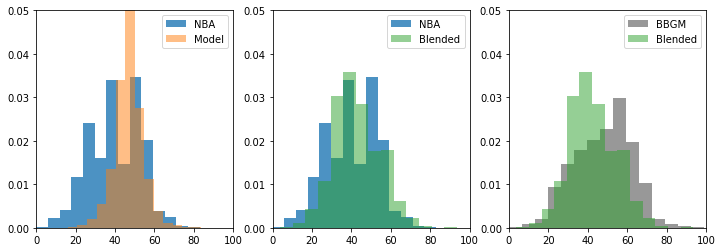

In [27]:
HGT_PRED = 0.5
player_heights = np.array(player_heights)

def normalize(fro,to):
    tm,ts = to.mean(),to.std()
    fm,fs = fro.mean(),fro.std()
    z = (fro-fm)/fs
    return z*ts + tm
nr = normalize(ratings[:,0],player_heights)
tmp = np.clip(HGT_PRED*np.array(player_heights) + (1-HGT_PRED)*np.maximum(nr,player_heights),0,100)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
_ = plt.hist(player_heights,15,alpha=0.8,density=True,label='NBA')
_ = plt.hist(np.clip(ratings[:,0],0,100),15,alpha=0.5,density=True,label='Model')
plt.xlim(0,100)
plt.ylim(0,0.05)
plt.legend()
plt.subplot(1,3,2)
_ = plt.hist(player_heights,15,alpha=0.8,density=True,label='NBA')
plt.hist(tmp,15,alpha=0.5,density=True,label='Blended',color='#2ca02c')
plt.xlim(0,100)
plt.ylim(0,0.05)
plt.legend()
plt.subplot(1,3,3)
_ = plt.hist(df['Hgt'],15,alpha=0.8,density=True,label='BBGM',color='#7f7f7f')
plt.hist(tmp,15,alpha=0.5,density=True,label='Blended',color='#2ca02c')
plt.xlim(0,100)
plt.ylim(0,0.05)
plt.legend()
plt.savefig('test.png',edgecolor='w',facecolor='w')

In [28]:

#ratings[:,0]
#table_columns['per_minute']#,table_columns['advanced'].index('0-3')
#for i,t in enumerate(player_stats[name]['advanced'][0]):
#    print(i,t)

In [29]:
#player_vectors[player_names.index('Joel Embiid')][list(X.columns).index('OWSp36')],X.columns[list(X.columns).index('OWSp36')]
#player_stats[2019]['Joel Embiid']['advanced'][0][12],player_stats[2019]['Joel Embiid']['per_game'][0][3]

(0, 100)

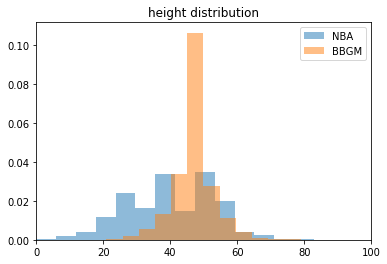

In [30]:
#_ = plt.hist(Xn[:,list(X.columns).index('FTp36')],150,density=True,alpha=0.5,label='NBA')
#_ = plt.hist(X['FTp36'],150,alpha=0.5,density=True,label='BBGM')
#plt.legend()
#plt.figure()
_ = plt.hist(player_heights,15,density=True,alpha=0.5,label='NBA')
_ = plt.hist(ratings[:,0],15,alpha=0.5,density=True,label='BBGM')
plt.title('height distribution')
plt.legend()
plt.xlim(0,100)

In [31]:
X.mean(0)-Xn.mean(0)

AtRimFGP          6.936645
LowPostFGP       -8.158180
MidRangeFGP   -1868.962532
3PAr            -16.276053
FTr             -11.548786
+/-              -0.074787
MP               18.633036
FGp36             1.186511
FGAp36            2.496694
3Pp36            -4.393813
3PAp36            3.491965
FTp36            -1.590879
FTAp36            2.761356
ORBp36           -1.666473
DRBp36            4.242274
TRBp36            0.476453
ASTp36            0.974527
TOVp36            1.128345
STLp36            0.434498
Blkp36           -1.585662
PFp36            -1.570142
PTSp36            2.634472
Creation        -14.679222
Load             -6.085054
cTOV              0.036360
DPM               0.790134
OPM              -0.213064
BPM               0.577070
Age               6.599002
dtype: float64

In [32]:
#for n,v in zip(X.columns,Xn.max(0)):
#    print(n,v)

In [33]:
rosters = {}

for team in all_tables[tyear[0]]:
    for name in all_tables[tyear[0]][team]['roster'].index:
        name = name.replace('\xa0\xa0',' ')
        nsplit = name.split(' ')
        if nsplit[-1] in ['Jr.','Sr.','I','II','III',"IV",'(TW)','Jr','Sr']:
            name = ' '.join(nsplit[:-1])
        rosters[name] = team
    #print(team,)
#print(rosters)

In [34]:
base = {'teams': [] }
tids = {_:i for i,_ in enumerate(sorted(set(rosters.values())))}
dids = {_:i for i,_ in enumerate(sorted(set(tables[_]['conf'] for _ in tables)))}

confs = sorted(list(set([tables[_]['conf'] for _ in tables])))
conf_to_id = {'aac': (0,1),
 'acc': (0,2),
 'america-east': (0,0),
 'atlantic-10': (0,1),
 'atlantic-sun': (0,2),
 'big-12': (1,3),
 'big-east': (1,4),
 'big-sky': (1,5),
 'big-south': (1,2),
 'big-ten': (0,1),
 'big-west': (1,5),
 'colonial': (0,0),
 'cusa': (0,2),
 'horizon':(0,1),
 'ivy':(0,1),
 'maac':(0,1),
 'mac':(0,1),
 'meac':(0,2),
 'mvc':(1,5),
 'mwc':(1,5),
 'northeast':(0,0),
 'ovc':(1,3),
 'pac-12':(1,4),
 'patriot':(1,3),
 'sec':(0,0),
 'southern':(0,2),
 'southland':(0,0),
 'summit':(1,4),
 'sun-belt':(1,3),
 'swac':(1,3),
 'wac':(1,5),
 'wcc':(1,4)}
abbrevs = set()
for team in sorted(tables):
    conf = tables[team]['conf']
    t = {'tid':tids[team],'cid':0,'did':dids[conf]}
    name = tables[team]['name'].replace('&amp;','&')
    nsplit = name.split(' ')
    t['region'] = ' '.join(nsplit[:-1])
    t['name'] = nsplit[-1]
    #t['abbrev'] = tables[team]['name'][:5]
    t["pop"] = 5
    t['stadiumCapacity'] = 25000
    t['imgURL'] = tables[team]['logo']
    abbr = ''.join([_[0] for _ in nsplit])
    if not abbr in abbrevs:
        t['abbrev'] = abbr
        abbrevs.add(abbr)
    else:
        abbr = name[:3].upper()
        if not abbr in abbrevs:
            t['abbrev'] = abbr
            abbrevs.add(abbr)
        else:
            t['abbrev'] = 'MISSB'
            abbrevs.add('MISSB')
    base['teams'].append(t)
CONFS = []
for c in confs:
    CONFS.append({'did':dids[c], 'cid':conf_to_id[conf][0], 'name':c.upper()})
    
base['gameAttributes'] = [{'key':'numGamesPlayoffSeries', 'value':[1 for i in range(5)]}]
base['gameAttributes'].append({'key':'divs', 'value': CONFS})

base['gameAttributes'].append({'key':'confs', 'value': [{"cid": 0, "name": "NCAA Basketball"}] })

for cid in range(2):
    print(cid,len([_ for _ in base['teams'] if _['cid'] ==cid]))
print()
for did in range(len(dids)):
    print(did,len([_ for _ in base['teams'] if _['did'] ==did]))
CONFS

0 353
1 0

0 12
1 15
2 9
3 14
4 9
5 10
6 10
7 11
8 11
9 14
10 9
11 10
12 14
13 10
14 8
15 11
16 12
17 12
18 10
19 11
20 10
21 12
22 12
23 10
24 14
25 10
26 13
27 9
28 12
29 10
30 9
31 10


[{'did': 0, 'cid': 0, 'name': 'AAC'},
 {'did': 1, 'cid': 0, 'name': 'ACC'},
 {'did': 2, 'cid': 0, 'name': 'AMERICA-EAST'},
 {'did': 3, 'cid': 0, 'name': 'ATLANTIC-10'},
 {'did': 4, 'cid': 0, 'name': 'ATLANTIC-SUN'},
 {'did': 5, 'cid': 0, 'name': 'BIG-12'},
 {'did': 6, 'cid': 0, 'name': 'BIG-EAST'},
 {'did': 7, 'cid': 0, 'name': 'BIG-SKY'},
 {'did': 8, 'cid': 0, 'name': 'BIG-SOUTH'},
 {'did': 9, 'cid': 0, 'name': 'BIG-TEN'},
 {'did': 10, 'cid': 0, 'name': 'BIG-WEST'},
 {'did': 11, 'cid': 0, 'name': 'COLONIAL'},
 {'did': 12, 'cid': 0, 'name': 'CUSA'},
 {'did': 13, 'cid': 0, 'name': 'HORIZON'},
 {'did': 14, 'cid': 0, 'name': 'IVY'},
 {'did': 15, 'cid': 0, 'name': 'MAAC'},
 {'did': 16, 'cid': 0, 'name': 'MAC'},
 {'did': 17, 'cid': 0, 'name': 'MEAC'},
 {'did': 18, 'cid': 0, 'name': 'MVC'},
 {'did': 19, 'cid': 0, 'name': 'MWC'},
 {'did': 20, 'cid': 0, 'name': 'NORTHEAST'},
 {'did': 21, 'cid': 0, 'name': 'OVC'},
 {'did': 22, 'cid': 0, 'name': 'PAC-12'},
 {'did': 23, 'cid': 0, 'name': 'PATRIOT

In [35]:

base['startingSeason'] = tyear[0]

y_keys = [_.lower() for _ in y.columns]

y_map = { 'hgt': 'hgt',
   'stre': 'str',
   'spd': 'spd',
   'jmp': 'jmp',
   'endu': 'end',
   'ins': 'ins',
   'dnk': 'dnk',
   'ft': 'ft.1',
   'fg': '2pt',
   'tp': '3pt',
   'diq': 'diq',
   'oiq': 'oiq',
   'drb': 'drb',
   'pss': 'pss',
   'reb': 'reb' }

In [36]:
if False:
    ri = 0
    _ = plt.hist(yt[:,ri],100,normed=True,alpha=0.5,label='predicted')
    _ = plt.hist(y.iloc[:,ri],100,normed=True,alpha=0.5,label='labels')
    _ = plt.hist(ratings[:,ri],100,normed=True,alpha=0.5,label='dataset')
    plt.xlim(-100,100)
    plt.legend()
elif False:
    plt.figure(figsize=(7*3,6*3))

    for ri in range(len(X.columns)):
        #ri = 13
        #plt.figure()
        plt.subplot(6,7,ri+1)

        _ = plt.hist(Xn[:,ri],100,density=True,alpha=0.5,label='NBA')
        _ = plt.hist(X.iloc[:,ri],100,density=True,alpha=0.5,label='BBGM')
        plt.legend()
        plt.title(X.columns[ri])# + ' ' + str(ri))
        plt.tight_layout()
        #plt.xlim(-100,100)
from collections import OrderedDict

def write_roman(num):

    roman = OrderedDict()
    roman[1000] = "M"
    roman[900] = "CM"
    roman[500] = "D"
    roman[400] = "CD"
    roman[100] = "C"
    roman[90] = "XC"
    roman[50] = "L"
    roman[40] = "XL"
    roman[10] = "X"
    roman[9] = "IX"
    roman[5] = "V"
    roman[4] = "IV"
    roman[1] = "I"

    def roman_num(num):
        for r in roman.keys():
            x, y = divmod(num, r)
            yield roman[r] * x
            num -= (r * x)
            if num <= 0:
                break

    return "".join([a for a in roman_num(num)])

In [37]:
if gen_FA > 0:
    player_names_f = player_names + ["Free Agent{}".format(write_roman(i)) for i in range(gen_FA)]
    player_years_f = player_years + [GEN_YEAR for i in range(gen_FA)]
    # scale them down, we don't want a bunch of amazing replacements
    MEAN_S = 0.95
    STD_S = 0.25
    rp_ratings = np.random.multivariate_normal(MEAN_S*replacement_player_mean_r,STD_S*replacement_player_cov_r,size=(gen_FA))
    ratings_f = np.vstack([ratings,rp_ratings])
else:
    player_names_f = player_names
    player_years_f = player_years
    ratings_f = ratings

In [38]:
import pprint
import copy
players = []
pp = pprint.PrettyPrinter()
for i,name in enumerate(player_names_f):
    py = player_years_f[i]
    name = player_names_f[i]
    sname = name.split(' ')
    new_player = {}
    new_player['firstName'] = sname[0]
    new_player['lastName'] = ' '.join(sname[1:])
    year_gap = 0
    if name in player_stats[py] and 'roster' in player_stats[py][name]:
        exp_years =  {'FR':0, 'SO':1,'JR':2,'SR':3, '0.0':2}[player_stats[py][name]['roster'][0][1]]

        year_gap = (py-GEN_YEAR) #0,1,2


        if py == GEN_YEAR and name in rosters:
            tid = tids[rosters[name]]
        elif exp_years != 0:
            continue
        elif py < GEN_YEAR:
            continue
        else:
            tid = [-2,-4,-5][year_gap-1]
        try:
            new_player['tid'] = tid
            new_player['pos'] = player_stats[py][name]['roster'][0][2].replace('-','')
            new_player['weight'] = int(float(player_stats[py][name]['roster'][0][4]))
            try:
                ht = [int(_) for _ in player_stats[py][name]['roster'][0][3].split('-')]
            except:
                ht = [6,6]
            age = {'FR':18, 'SO':19,'JR':20,'SR':21, '0.0':20}[player_stats[py][name]['roster'][0][1]]
            new_player['born'] = {'year':GEN_YEAR-age,'loc':''}

            new_player['hgt'] = ht[0]*12 + ht[1]
            new_player['draft'] = {'year':py-exp_years,"round": 0, "pick": 0, "tid": -1, "originalTid": -1,}
        except:
            print(name)
            raise
            continue
        try:
            br = CURRENT_YEAR-{'FR':18, 'SO':19,'JR':20,'SR':21, '0.0':20}[player_stats[py][name]['roster'][0][1]]
        except:
            br = py-30
            new_player['born'] = {'year':br,'loc':''}
    elif name in player_stats[py]:
        #print(name)
        if py == GEN_YEAR:
            tid = -1
        else:
            continue
        if py-1 in player_stats and name in player_stats[py-1]:
            exp_years =  player_stats[py-1][name]['roster'][0][4]
            exp_years = int(0 if exp_years == 'R' else exp_years)
            new_player['weight'] = int(float(player_stats[py-1][name]['roster'][0][4]))
            ht = [int(_) for _ in player_stats[py-1][name]['roster'][0][1].split('-')]
            new_player['pos'] = player_stats[py-1][name]['roster'][0][0].replace('-','')
            new_player['hgt'] = ht[0]*12 + ht[1]
            new_player['born'] = {'year':GEN_YEAR-{'FR':18, 'SO':19,'JR':20,'SR':21, '0.0':20}[player_stats[py][name]['roster'][0][1]],'loc':''}
            new_player['draft'] = {'year':py-exp_years+1,"round": 0, "pick": 0, "tid": -1, "originalTid": -1}
        else:     
            new_player['pos'] = 'GF'
            new_player['weight'] = 200
            new_player['hgt'] = 6*12 + 8
            new_player['born'] = {'year':GEN_YEAR-28,'loc':''}
        new_player['tid'] = tid
    elif i > Xn.shape[0]:
        #print(name)
        new_player['tid'] = int(-1)
        new_player['weight'] = int(np.random.normal(220,20))
        new_player['hgt'] = int(np.random.normal(6*12+6,3))
        new_player['born'] = {'year':int(GEN_YEAR-np.random.normal(32,2)),'loc':''}
        new_player['pos'] = "GF"
        #print(new_player)
    else:
        #print(name)
        continue
    #if name == 'Ben Simmons':
    #    print(new_player)
    #print(year_gap,py,name)
    try:
        scale_rookie = [1.0,1.0,1.0,1.0][year_gap]
        sub_rookie = [0,-2,-4,-6][year_gap]
        r_vec = {k: scale_rookie*ratings_f[i,y_keys.index(km)]+sub_rookie for k,km in y_map.items()}
        #print(y_map.keys())
        r_vec['endu'] -= 4.5*min(1,year_gap)
        r_vec['diq'] -= 4*min(1,year_gap)
        r_vec['oiq'] -= 4*min(1,year_gap)
        r_vec = {k: int(np.clip(v,0,100)) for k,v in r_vec.items()}

        new_player['ratings'] = [r_vec]
        #new_player['ratings']
        players.append(new_player)
    except:
        print(name)
        raise
    #if name in ['Luka Doncic']: #"Trevon Duval",'LeBron James'
        #print(py,exp_years)
    #    pp.pprint(new_player)
        #pp.pprint(player_vectors[player_names.index(name)])

In [39]:
base['players'] = players
with open('cbb_roster_{}.json'.format(tyear[0]),'wt') as fp:
    json.dump(base,fp, sort_keys=True)

In [ ]:
len(ratings),len(ratings_f),len(ratings)+gen_FA

In [ ]:
[(_['region'],_['tid']) for _ in base['teams']]